In [ ]:
import os
import tarfile
from google.colab import drive

drive_path = ('drive')
drive.mount(os.path.join(os.getcwd(), drive_path))

tar = tarfile.open('/content/drive/My Drive/Colab Notebooks/datasets/ChestX-ray8.tar', 'r')
tar.extractall(os.path.join(os.getcwd(), 'data'))

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git data/covid-chestxray-dataset
#!cd data/covid-chestxray-dataset && git checkout fad61392f6e3c5a71fb3fb3a89f7d8dbd90b8730

Cloning into 'data/covid-chestxray-dataset'...
remote: Enumerating objects: 3629, done.
remote: Total 3629 (delta 0), reused 0 (delta 0), pack-reused 3629
Receiving objects: 100% (3629/3629), 632.96 MiB | 31.30 MiB/s, done.
Resolving deltas: 100% (1442/1442), done.
Checking out files: 100% (1173/1173), done.


In [ ]:
!find data/covid-chestxray-dataset/images -type f | wc -l

930


In [ ]:
import os
drive_path = ('drive')
config = {
  'PATHS': {
    'RAW_DATA': os.path.join(os.getcwd(), 'data'),
    'COVID_CHEST_XRAY_DATA': os.path.join(os.getcwd(), 'data', 'covid-chestxray-dataset'),
    'CHEST_XRAY_8_DATA': os.path.join(os.getcwd(), 'data', 'ChestX-ray8'),
    'PROCESSED_DATA': os.path.join(os.getcwd(), 'data', 'processed'),
    'TRAIN_SET': os.path.join(os.getcwd(), 'data', 'processed', 'train_set.csv'),
    'VAL_SET': os.path.join(os.getcwd(), 'data', 'processed', 'val_set.csv'),
    'TEST_SET': os.path.join(os.getcwd(), 'data', 'processed', 'test_set.csv'),
    'IMAGES': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'output', 'documents', 'generated_images'),
    'LOGS': os.path.join(os.getcwd(), 'results', 'logs'),
    'CHECKPOINTS': os.path.join(os.getcwd(), 'model', 'checkpoints'),
    'MODELS_FOLDER': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid'),
    'MODEL_WEIGHTS': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model_weights20200531-103213.index'),
    'MODEL_TO_LOAD': '/content/drive/My Drive/Colab Notebooks/models/model_covid/model_ft20210213-193045.h5',
    #'MODEL_TO_LOAD': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model20200826-140506.h5'),
    'OUTPUT_CLASS_INDICES': os.path.join(os.getcwd(), 'data', 'interpretability', 'output_class_indices.pkl'),
    'LIME_EXPLAINER': os.path.join(os.getcwd(), 'data', 'interpretability', 'lime_explainer.pkl'),
    'UNET_MODEL_PATH': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'lung_segmentation', 'lung_segmentation_model.hdf5')
  },
  'DATA': {
    'IMG_DIM': tuple([331])*2,
    'VIEW': 'PA',
    'VAL_SPLIT_PERCENT': 0.08,
    'TEST_SPLIT_PERCENT': 0.1,
    'NUM_CHEST_XRAY_8_IMAGES': 1000,
    'RESIZE_WITH_PADDING': True,
    'CLASSES': [
      'NO FINDING',
      'COVID-19'
    ],
    'OTHER_CONTAINS_ONLY_HEALTHY': True,
    # One of {'class_weight', 'reduce'}
    'CLASS_BALANCE_STRATEGY': 'reduce'      
  },
  'SEGMENTATION': {
    'IMG_DIM': tuple([256])*2,
    'MORPHOLOGY_KERNEL_SIZE': tuple([5])*2,
    'DILATION_KERNEL_SIZE': tuple([2])*2,
    'DILATION_ITERATIONS': 3,
    'MASK_BINARIZATION_TRESHOLD': 0.25
  },
  'TRAIN': {
    'BATCH_SIZE': 32,
    'FT_BATCH_SIZE': 16,
    'EPOCHS': 150,
    'THRESHOLDS': 0.5,
    'ENABLE_EARLY_STOPPING': True,
    'PATIENCE_FOR_EARLY_STOPPING': 10,
    'NUM_GPUS': 1
  },
  'NN': {
    'NODES_DENSE0': 256,
    'LR': 0.00001,
    'FT_LR': 0.000001,
    'OPTIMIZER': 'adam',
    'DROPOUT': 0.3,
    'L2_LAMBDA': 0.0001
  },
  'LIME': {
    'KERNEL_WIDTH': 4,
    'FEATURE_SELECTION': 'lasso_path',
    'NUM_FEATURES': 1000,
    'NUM_SAMPLES': 1000,
    'COVID_ONLY': False
  },
  'PREDICTION': {
    'THRESHOLD': 0.5
  }
}

In [ ]:
from pathlib import Path
import re

for path in config['PATHS']:
  if not bool(re.match('^.*\.[a-zA-Z0-9]+$', config['PATHS'][path])):
    Path(config['PATHS'][path]).mkdir(parents=True, exist_ok=True)
  else:
    splitted_path = config['PATHS'][path][:config['PATHS'][path].rfind('/')]
    Path(splitted_path).mkdir(parents=True, exist_ok=True)

In [ ]:
import pandas as pd

covid_chest_xray_path = config['PATHS']['COVID_CHEST_XRAY_DATA']
chest_xray_8_path = config['PATHS']['CHEST_XRAY_8_DATA']

covid_chest_xray_df = pd.read_csv(os.path.join(covid_chest_xray_path, 'metadata.csv'))
covid_chest_xray_df['filename'] = [os.path.join(covid_chest_xray_path, 'images', row) for row in covid_chest_xray_df['filename'].astype(str)]

covid_views_cxrs_df = covid_chest_xray_df['view'].str.match(config['DATA']['VIEW'])
covid_pos_df = covid_chest_xray_df['finding'].str.contains('COVID-19')
covid_df = covid_chest_xray_df[covid_pos_df & covid_views_cxrs_df] 

chest_xray_8_df = pd.read_csv(os.path.join(chest_xray_8_path, 'subset.csv'))
num_chest_xray_8_imgs = config['DATA']['NUM_CHEST_XRAY_8_IMAGES']
chest_xray_8_normal_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('No Finding')]
chest_xray_8_pneum_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('(?!No Finding)')]

chest_xray_8_normal_sample_df = chest_xray_8_normal_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_normal_df.shape[0], random_state=num_chest_xray_8_imgs)

chest_xray_8_pneum_sample_df = chest_xray_8_pneum_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_pneum_df.shape[0], random_state=num_chest_xray_8_imgs)

if config['DATA']['OTHER_CONTAINS_ONLY_HEALTHY']:
  chest_xray_8_df = chest_xray_8_normal_sample_df
else:
  chest_xray_8_df = pd.concat([chest_xray_8_normal_sample_df, chest_xray_8_pneum_sample_df], axis=0)

chest_xray_8_df['filename'] = [os.path.join(chest_xray_8_path, row) for row in chest_xray_8_df['Image Index'].astype(str)]

In [ ]:
covid_df['label'] = 'COVID-19'
chest_xray_8_df['label'] = 'NO FINDING'

chest_xray_8_selected_df = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'reduce':
  chest_xray_8_selected_df = chest_xray_8_df.head(covid_df.shape[0])
else:
  chest_xray_8_selected_df = chest_xray_8_df

file_df = pd.concat(
        [covid_df[['filename', 'label']],
        chest_xray_8_selected_df[['filename', 'label']]], axis=0)         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
from PIL import Image

def resize_with_pad(file_path, img_size):
  img = Image.open(file_path)
  old_size = img.size  
  ratio = float(img_size) / max(old_size)
  new_size = tuple([int(x * ratio) for x in old_size])

  img = img.resize(new_size, Image.ANTIALIAS)

  new_img = Image.new("RGB", (img_size, img_size))
  new_img.paste(img, ((img_size - new_size[0]) // 2,
                  (img_size - new_size[1]) // 2))
  return new_img

for file_path in file_df['filename']:
  if config['DATA']['RESIZE_WITH_PADDING']:
    padded_img = resize_with_pad(file_path, config['DATA']['IMG_DIM'][0])
    padded_img.save(file_path)

In [ ]:
# from https://github.com/imlab-uiip/lung-segmentation-2d
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
UNet = load_model(config['PATHS']['UNET_MODEL_PATH'])

In [ ]:
import numpy as np
import pandas as pd
from skimage import morphology, color, io, exposure, transform

def mask_image(image, mask):
    """Returns masked image"""
    return np.ma.masked_where(mask == 0, image)
     

def remove_small_regions_and_dilate(image):
    """Morphologically removes small (less than kernel size) connected regions of 0s or 1s and dilates mask"""

    morphology_kernel = np.ones(config['SEGMENTATION']['MORPHOLOGY_KERNEL_SIZE'], np.uint8)
    dilation_kernel = np.ones(config['SEGMENTATION']['DILATION_KERNEL_SIZE'], np.uint8)
    image = np.squeeze(image).astype(np.float32)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, morphology_kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, morphology_kernel)
    image = cv2.dilate(image, dilation_kernel, iterations = config['SEGMENTATION']['DILATION_ITERATIONS'])

    return image

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

masked_filenames = []

for row in file_df.iterrows():
  file_name = row[1][0]
  dot_index = file_name.rfind('.')
  masked_image_filename = '{}{}{}'.format(file_name[:dot_index], '_masked', file_name[dot_index:])
  mask_filename = '{}{}{}'.format(file_name[:dot_index], '_mask', file_name[dot_index:])
  original_image = cv2.imread(file_name, 0).astype(np.float32)/255.0
  original_image_size = original_image.shape[::-1]
  
  downsized_image = cv2.resize(original_image, dsize=config['SEGMENTATION']['IMG_DIM'], interpolation=cv2.INTER_CUBIC)
  downsized_image = np.expand_dims(downsized_image, axis=0)
  downsized_image = tf.image.per_image_standardization(downsized_image)

  mask_prediction = UNet.predict(downsized_image)

  mask = mask_prediction > config['SEGMENTATION']['MASK_BINARIZATION_TRESHOLD']
  mask = remove_small_regions_and_dilate(mask)
  upsized_mask = cv2.resize(np.squeeze(mask).astype(np.float32), dsize=original_image_size, interpolation=cv2.INTER_CUBIC)
  masked_image = mask_image(original_image, upsized_mask)
  cv2.imwrite(mask_filename, upsized_mask*255)
  cv2.imwrite(masked_image_filename, masked_image*255)
  masked_filenames.append(masked_image_filename)
  
file_df.insert(1, 'masked_filename', masked_filenames)

In [ ]:
from sklearn.model_selection import train_test_split

validation_split_size = config['DATA']['VAL_SPLIT_PERCENT']
test_split_size = config['DATA']['TEST_SPLIT_PERCENT']
file_df_train, file_df_test = train_test_split(file_df, test_size=test_split_size, stratify=file_df['label'], random_state=42)
relative_validation_split_size = validation_split_size / (1 - test_split_size)
file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_validation_split_size,
                                                    stratify=file_df_train['label'], random_state=42)

if not os.path.exists(config['PATHS']['PROCESSED_DATA']):
    os.makedirs(config['PATHS']['PROCESSED_DATA'])
file_df_train.to_csv(config['PATHS']['TRAIN_SET'])
file_df_val.to_csv(config['PATHS']['VAL_SET'])
file_df_test.to_csv(config['PATHS']['TEST_SET'])

In [ ]:
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(config['PATHS']['LOGS'], 'training', cur_date)
model_filename = 'weights.{epoch:02d}-{auc:.2f}.hdf5'
model_filename_single = 'weights.hdf5'
checkpoint_path = os.path.join(config['PATHS']['CHECKPOINTS'], model_filename)
print(checkpoint_path)
if not os.path.exists(os.path.join(config['PATHS']['LOGS'], 'training')):
    os.makedirs(os.path.join(config['PATHS']['LOGS'], 'training'))
    
data = {}
data['TRAIN'] = pd.read_csv(config['PATHS']['TRAIN_SET'])
data['VAL'] = pd.read_csv(config['PATHS']['VAL_SET'])
data['TEST'] = pd.read_csv(config['PATHS']['TEST_SET'])

callbacks = []
if config['TRAIN']['ENABLE_EARLY_STOPPING']:
  early_stopping = EarlyStopping(
    monitor='val_auc_pr',
    verbose=1, 
    patience=config['TRAIN']['PATIENCE_FOR_EARLY_STOPPING'], 
    mode='max', 
    restore_best_weights=True)
  callbacks.append(early_stopping)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard)
model_checkpoint = ModelCheckpoint(model_filename_single, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch'
)
callbacks.append(model_checkpoint)

/content/model/checkpoints/weights.{epoch:02d}-{auc:.2f}.hdf5


Found 320 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  ...
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]]

 [[-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  ...
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]]

 [[-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  ...
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]]

 ...

 [[-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  ...
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]
  [-0.62741774 -0.62741774 -0.62741774]]

 [

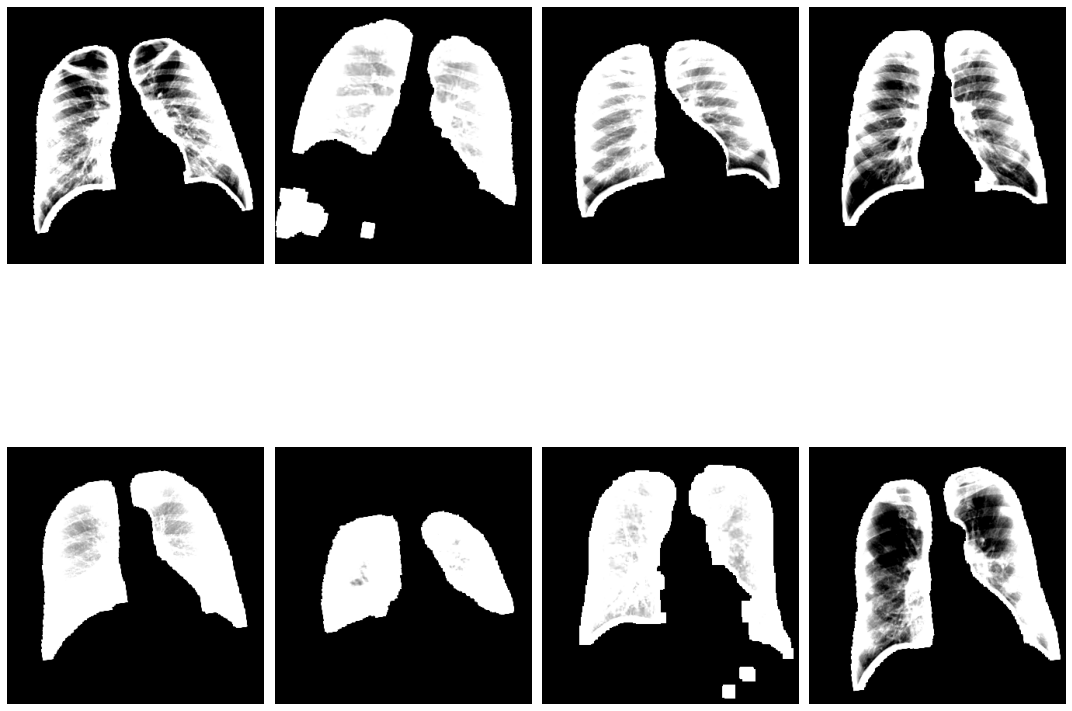

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import dill

train_img_gen = ImageDataGenerator(rotation_range=10, samplewise_std_normalization=True, samplewise_center=True)
val_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)
test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

class_mode = 'categorical'
train_generator = train_img_gen.flow_from_dataframe(
    dataframe=data['TRAIN'],
    x_col='masked_filename',
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
val_generator = val_img_gen.flow_from_dataframe(
    dataframe=data['VAL'],
    x_col="masked_filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
test_generator = test_img_gen.flow_from_dataframe(
    dataframe=data['TEST'],
    x_col="masked_filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True,
    shuffle=False)

dill.dump(test_generator.class_indices, open(config['PATHS']['OUTPUT_CLASS_INDICES'], 'wb+'))

histogram = np.bincount(np.array(train_generator.labels).astype(int))

class_weight = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'class_weight':
  class_multiplier_list = [min(histogram) / max(histogram)]
  class_multiplier_list.insert(int(histogram[0] > histogram[1]), 1.0)

  class_multiplier = [
          class_multiplier_list[config['DATA']['CLASSES'].index(c)]
              for c in test_generator.class_indices
  ]

  weights = [(1.0 / len(histogram)) * sum(histogram) / histogram[i] for i in range(len(histogram))]

  class_weight = {i: class_multiplier[i] for i in range(len(histogram))}  

x,y = train_generator.next()
train_generator.reset()

fig,ax=plt.subplots(2,4)
fig.set_size_inches(15,15)
num = 0
for i in range(2):
  for j in range(4):
    print(x[num])
    ax[i,j].imshow(x[num])
    ax[i,j].axis('off')
    num += 1
        
plt.tight_layout()

In [ ]:
!rm -R /content/results

In [ ]:
pip install tensorflow_addons

     |████████████████████████████████| 706kB 13.2MB/s 


In [ ]:
from tensorflow.keras.metrics import (AUC, CategoricalAccuracy,
                                      CategoricalCrossentropy,
                                      MeanAbsolutePercentageError, Precision,
                                      Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, 
                                      SpecificityAtSensitivity, SensitivityAtSpecificity)
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, Activation, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import Constant
from tensorflow.keras.applications import NASNetLarge

covid_class_idx = test_generator.class_indices['COVID-19']   
thresholds = 1.0 / len(config['DATA']['CLASSES'])
metrics = [CategoricalAccuracy(name='c_accuracy'),
    Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
    Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
    AUC(name='auc_pr', curve='PR'),
    AUC(name='auc_roc', curve='ROC'),
    F1Score(name='f1score', threshold=thresholds, num_classes=len(config['DATA']['CLASSES'])), 
    TrueNegatives(name='tn'), 
    TruePositives(name='tp'), 
    FalseNegatives(name='fn'), 
    FalsePositives(name='fp'),
    SpecificityAtSensitivity(sensitivity=0.5, name='speAtSen'),
    SensitivityAtSpecificity(specificity=0.5, name='senAtSpe')]

input_shape = config['DATA']['IMG_DIM']+tuple([3])
num_gpus = config['TRAIN']['NUM_GPUS']

model_config = config['NN']

nodes_dense0 = model_config['NODES_DENSE0']
lr = model_config['LR']
dropout = model_config['DROPOUT']
l2_lambda = model_config['L2_LAMBDA']

if model_config['OPTIMIZER'] == 'sgd':
    optimizer = SGD(learning_rate=lr)
else:
    optimizer = Adam(learning_rate=lr)

histogram = np.bincount([config['DATA']['CLASSES'].index(label) for label in data['TRAIN']['label'].astype(str)])
output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])

# Set output bias
if output_bias is not None:
    output_bias = Constant(output_bias)
print("MODEL CONFIG: ", model_config)

X_input = Input(input_shape, name='input_img')
base_model = NASNetLarge(include_top=False, weights='imagenet', input_shape=input_shape, input_tensor=X_input)
base_model.trainable = False
X = base_model(X_input, training=False)

# Add custom top
X = GlobalMaxPooling2D()(X)
X = Dropout(dropout)(X)
X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
X = LeakyReLU()(X)
X = Dense(len(config['DATA']['CLASSES']), bias_initializer=output_bias)(X)
Y = Activation('softmax', dtype='float32', name='output')(X)

model = Model(inputs=X_input, outputs=Y)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

MODEL CONFIG:  {'NODES_DENSE0': 256, 'LR': 1e-05, 'FT_LR': 1e-06, 'OPTIMIZER': 'adam', 'DROPOUT': 0.3, 'L2_LAMBDA': 0.0001}
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 4032)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4032)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1032448   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_

In [ ]:
history = model.fit(train_generator, epochs=config['TRAIN']['EPOCHS'],
                                validation_data=val_generator, callbacks=callbacks,
                                verbose=True, class_weight=class_weight)

Epoch 1/150
10/10 [==============================] - 34s 2s/step - loss: 3.7462 - c_accuracy: 0.4895 - precision: 0.5272 - recall: 0.2530 - auc_pr: 0.5019 - auc_roc: 0.4982 - f1score: 0.4576 - tn: 92.0909 - tp: 92.0909 - fn: 97.0000 - fp: 97.0000 - speAtSen: 0.4884 - senAtSpe: 0.4884 - val_loss: 1.8480 - val_c_accuracy: 0.5625 - val_precision: 0.5455 - val_recall: 0.7500 - val_auc_pr: 0.5680 - val_auc_roc: 0.5850 - val_f1score: 0.5466 - val_tn: 18.0000 - val_tp: 18.0000 - val_fn: 14.0000 - val_fp: 14.0000 - val_speAtSen: 0.6875 - val_senAtSpe: 0.6875

Epoch 00001: val_auc_pr improved from -inf to 0.56803, saving model to weights.hdf5
Epoch 2/150
10/10 [==============================] - 10s 996ms/step - loss: 3.3755 - c_accuracy: 0.4585 - precision: 0.4669 - recall: 0.5984 - auc_pr: 0.4989 - auc_roc: 0.4905 - f1score: 0.4467 - tn: 89.1818 - tp: 89.1818 - fn: 99.9091 - fp: 99.9091 - speAtSen: 0.4262 - senAtSpe: 0.4262 - val_loss: 1.6497 - val_c_accuracy: 0.5625 - val_precision: 0.5500 - 

In [ ]:
import json

hist_df = pd.DataFrame(history.history) 

# save fine-tuning history to json:  
hist_json_file = '/content/history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
evaluation = model.evaluate(test_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

# save evaluation to json:  
evaluation_json_file = '/content/evaluation.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

2/2 [==============================] - 1s 174ms/step - loss: 0.9036 - c_accuracy: 0.7500 - precision: 0.8571 - recall: 0.6000 - auc_pr: 0.8638 - auc_roc: 0.8519 - f1score: 0.7442 - tn: 30.0000 - tp: 30.0000 - fn: 10.0000 - fp: 10.0000 - speAtSen: 0.9250 - senAtSpe: 0.9250


In [ ]:
from tensorflow.keras.models import save_model, load_model

model_path = os.path.join(config['PATHS']['MODELS_FOLDER'], '{}{}{}'.format('model', cur_date, '.h5'))
save_model(model, model_path)
model_path

'/content/drive/My Drive/Colab Notebooks/models/model_covid/model20210213-175957.h5'

In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/models/model_covid/model20210213-175957.h5')

Found 320 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  ...
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]]

 [[-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  ...
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]]

 [[-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  ...
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]]

 ...

 [[-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  ...
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]
  [-0.57909685 -0.57909685 -0.57909685]]

 [

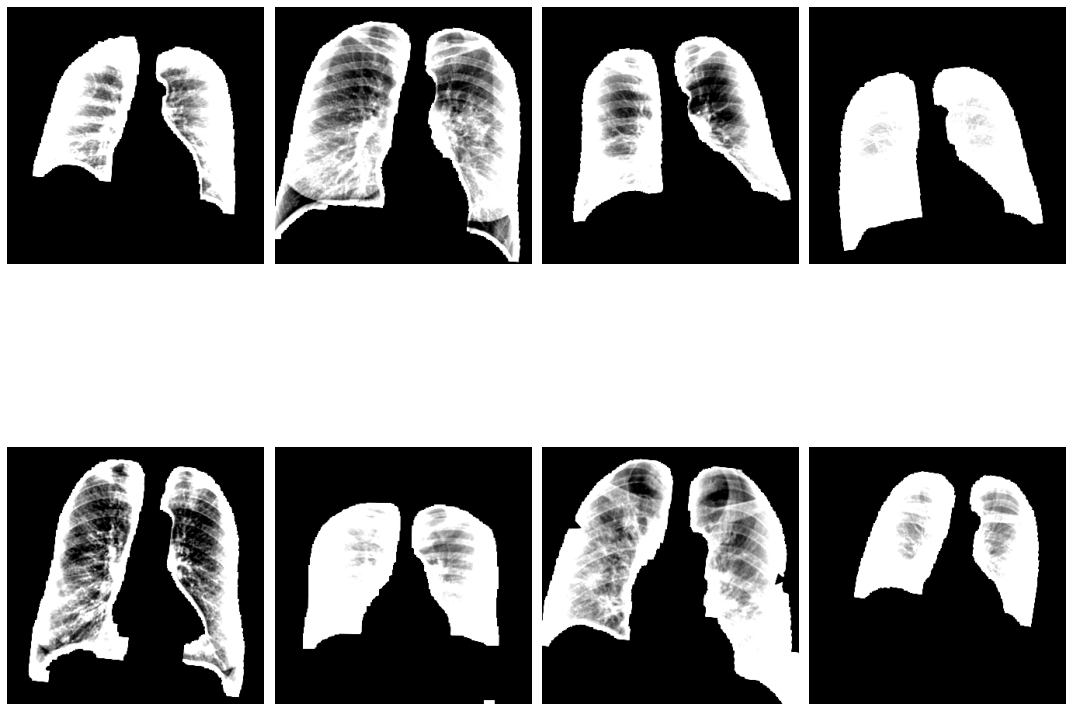

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import dill

train_img_gen = ImageDataGenerator(rotation_range=10, samplewise_std_normalization=True, samplewise_center=True)
val_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)
test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

class_mode = 'categorical'
train_generator = train_img_gen.flow_from_dataframe(
    dataframe=data['TRAIN'],
    x_col='masked_filename',
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['FT_BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
val_generator = val_img_gen.flow_from_dataframe(
    dataframe=data['VAL'],
    x_col="masked_filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['FT_BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
test_generator = test_img_gen.flow_from_dataframe(
    dataframe=data['TEST'],
    x_col="masked_filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['FT_BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True,
    shuffle=False)

#dill.dump(test_generator.class_indices, open(config['PATHS']['OUTPUT_CLASS_INDICES'], 'wb+'))

histogram = np.bincount(np.array(train_generator.labels).astype(int))

class_weight = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'class_weight':
  class_multiplier_list = [min(histogram) / max(histogram)]
  class_multiplier_list.insert(int(histogram[0] > histogram[1]), 1.0)

  class_multiplier = [
          class_multiplier_list[config['DATA']['CLASSES'].index(c)]
              for c in test_generator.class_indices
  ]

  weights = [(1.0 / len(histogram)) * sum(histogram) / histogram[i] for i in range(len(histogram))]

  class_weight = {i: class_multiplier[i] for i in range(len(histogram))}  

x,y = train_generator.next()
train_generator.reset()

fig,ax=plt.subplots(2,4)
fig.set_size_inches(15,15)
num = 0
for i in range(2):
  for j in range(4):
    print(x[num])
    ax[i,j].imshow(x[num])
    ax[i,j].axis('off')
    num += 1
        
plt.tight_layout()

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename_ft = 'fine_tuning_weights.hdf5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

callbacks_ft = []
early_stopping_ft = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=3, 
  mode='max', 
  restore_best_weights=True)

callbacks_ft.append(early_stopping_ft)

tensorboard_ft = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_ft.append(tensorboard_ft)
model_checkpoint_ft = ModelCheckpoint(model_filename_ft, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks_ft.append(model_checkpoint_ft)

In [ ]:
base_model.trainable = True

lr = model_config['FT_LR']

if model_config['OPTIMIZER'] == 'sgd':
    optimizer = SGD(learning_rate=lr)
else:
    optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 4032)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4032)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1032448   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514 

In [ ]:
fine_tune_epochs = 30
last_epoch = history.epoch[-1] - config['TRAIN']['PATIENCE_FOR_EARLY_STOPPING'] + 1
total_epochs = last_epoch + fine_tune_epochs

history_fine = model.fit(train_generator, 
                          epochs=total_epochs,                          
                          initial_epoch=last_epoch,
                          validation_data=val_generator, 
                          callbacks=callbacks_ft,
                          verbose=True, class_weight=class_weight)

Epoch 56/85
20/20 [==============================] - 73s 2s/step - loss: 1.0493 - c_accuracy: 0.8134 - precision: 0.8092 - recall: 0.7853 - auc_pr: 0.8821 - auc_roc: 0.8877 - f1score: 0.8119 - tn: 175.9048 - tp: 175.9048 - fn: 39.3333 - fp: 39.3333 - speAtSen: 0.9487 - senAtSpe: 0.9487 - val_loss: 0.8931 - val_c_accuracy: 0.6875 - val_precision: 0.8000 - val_recall: 0.5000 - val_auc_pr: 0.8695 - val_auc_roc: 0.8525 - val_f1score: 0.6761 - val_tn: 22.0000 - val_tp: 22.0000 - val_fn: 10.0000 - val_fp: 10.0000 - val_speAtSen: 1.0000 - val_senAtSpe: 1.0000

Epoch 00056: val_auc_pr improved from -inf to 0.86950, saving model to fine_tuning_weights.hdf5
Epoch 57/85
20/20 [==============================] - 33s 2s/step - loss: 1.1558 - c_accuracy: 0.8166 - precision: 0.8019 - recall: 0.7879 - auc_pr: 0.8594 - auc_roc: 0.8750 - f1score: 0.8121 - tn: 146.1905 - tp: 146.1905 - fn: 29.0476 - fp: 29.0476 - speAtSen: 0.9425 - senAtSpe: 0.9425 - val_loss: 0.8176 - val_c_accuracy: 0.6875 - val_precisi

In [ ]:
test_results = model.evaluate(test_generator, verbose=1)

3/3 [==============================] - 1s 240ms/step - loss: 0.7564 - c_accuracy: 0.8000 - precision: 0.8750 - recall: 0.7000 - auc_pr: 0.9003 - auc_roc: 0.8913 - f1score: 0.7980 - tn: 32.0000 - tp: 32.0000 - fn: 8.0000 - fp: 8.0000 - speAtSen: 1.0000 - senAtSpe: 1.0000


In [ ]:
model.load_weights('/content/weights.hdf5')

In [ ]:
import json

hist_ft_df = pd.DataFrame(history_fine.history) 

# save fine-tuning history to json:  
hist_ft_json_file = '/content/history_fine.json'
with open(hist_ft_json_file, mode='w') as f:
    hist_ft_df.to_json(f)

In [ ]:
evaluation = model.evaluate(test_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

# save evaluation to json:  
evaluation_json_file = '/content/evaluation_ft.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

3/3 [==============================] - 1s 242ms/step - loss: 0.7564 - c_accuracy: 0.8000 - precision: 0.8750 - recall: 0.7000 - auc_pr: 0.9003 - auc_roc: 0.8913 - f1score: 0.7980 - tn: 32.0000 - tp: 32.0000 - fn: 8.0000 - fp: 8.0000 - speAtSen: 1.0000 - senAtSpe: 1.0000


In [ ]:
from tensorflow.keras.models import save_model, load_model

model_path = os.path.join(config['PATHS']['MODELS_FOLDER'], '{}{}{}'.format('model_ft', cur_date, '.h5'))
save_model(model, model_path)
model_path

'/content/drive/My Drive/Colab Notebooks/models/model_covid/model_ft20210213-193045.h5'

In [ ]:
pip install lime

     |████████████████████████████████| 276kB 12.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=e31e4a9d226de38159a4c3b1db894d433a382f39f12aa386da817f1abd24693e
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
lime_dict = {
  'NUM_SAMPLES': config['LIME']['NUM_SAMPLES'],
  'NUM_FEATURES': config['LIME']['NUM_FEATURES'],
  'IMG_PATH': config['PATHS']['IMAGES'],
  'RAW_DATA_PATH': config['PATHS']['RAW_DATA'],
  'IMG_DIM': config['DATA']['IMG_DIM'],
  'PRED_THRESHOLD': config['PREDICTION']['THRESHOLD'],
  'CLASSES': config['DATA']['CLASSES'],
  'COVID_ONLY': config['LIME']['COVID_ONLY'],
  'KERNEL_WIDTH': config['LIME']['KERNEL_WIDTH'],
  'FEATURE_SELECTION': config['LIME']['FEATURE_SELECTION']
}

In [ ]:
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.models import load_model

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

NUM_TEST_IMG = data['TEST'].shape[0]

lime_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=config['DATA']['IMG_DIM'], batch_size=1,
    class_mode='categorical', validate_filenames=False, shuffle=False)

lime_explainer = LimeImageExplainer(kernel_width=lime_dict['KERNEL_WIDTH'], feature_selection=lime_dict['FEATURE_SELECTION'],
                                            verbose=True)
dill.dump(lime_explainer, open(config['PATHS']['LIME_EXPLAINER'], 'wb'))

lime_model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False)

Found 40 non-validated image filenames belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries
from lime.lime_image import SegmentationAlgorithm

def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):

    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10, hide_rest=False)
    return mark_boundaries(temp, mask)
    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10, hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.5, 0.9, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.9, "Predicted Class: " + str(pred_class) + ' (' + class_names[int(pred_class)] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.85, "Ground Truth Class: " + str(class_names.index(label)) + ' (' + label + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=13)
    fig.tight_layout()
    plt.show()
    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = os.path.join(dir_path, img_filename.split('/')[-1] + '_exp_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.svg')
        plt.savefig(filename)
    return filename

lime_test_generator.reset()
def get_lime_explanation(orig_img, label):
  x, _ = lime_test_generator.next()
  x = np.squeeze(x, axis=0)

  # Get the corresponding original image (no preprocessing)
  orig_img# = cv2.imread(data['TEST']['masked_filename'][idx])
  new_dim = (lime_dict['IMG_DIM'])
  orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

  # Make a prediction for this image and retrieve a LIME explanation for the prediction
  start_time = datetime.datetime.now()

  def predict(x):
      '''
      Helper function for LIME explainer. Runs model prediction on perturbations of the example.
      :param x: List of perturbed examples from an example
      :return: A numpy array constituting a list of class probabilities for each predicted perturbation
      '''
      y = lime_model.predict(x)  # Run prediction on the perturbations
      if y.shape[1] == 1:
          probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
      else:
          probs = y
      return probs

  # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
  segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)
  # Generate explanation for the example
  explanation = lime_explainer.explain_instance(x.astype(np.double), predict, num_features=lime_dict['NUM_FEATURES'], num_samples=lime_dict['NUM_SAMPLES'], segmentation_fn=segmentation_fn)
  probs = predict(np.expand_dims(x, axis=0))

  print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")

  # Get image filename and label
  img_filename = None #data['TEST']['masked_filename'][idx]
  label = None# data['TEST']['label'][idx]

  # Rearrange prediction probability vector to reflect original ordering of classes in project config
  probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_test_generator.class_indices]

  # Visualize the LIME explanation and optionally save it to disk
  file_path = lime_dict['IMG_PATH']
  explanation_filenames = []
  if lime_dict['COVID_ONLY'] == True:
      label_to_see = lime_test_generator.class_indices['COVID-19']
  else:
      label_to_see = 'top'
  expalanation_filename = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                        dir_path=file_path)
  explanation_filenames.append(expalanation_filename)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False)

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

img = gradcam_test_generator.next()

Found 40 validated image filenames belonging to 2 classes.


In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
   
class My_GradCAM:
  def __init__(self, model, classIdx, inner_model=None, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.inner_model = inner_model
    if self.inner_model == None:
      self.inner_model = model
    self.layerName = layerName 
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.inner_model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")       

  def compute_heatmap(self, image, eps=1e-8):
    '''
    Computes heatmap of given image
    :return: heatmap
    '''
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = tf.keras.models.Model(
        inputs=[
            self.inner_model.inputs
        ],
        outputs=[
            self.inner_model.get_layer(self.layerName).output,
            self.inner_model.output
        ]
    )                                   
    
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    heatmap = tf.reduce_mean(heatmap, axis=(0, 1))
    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0, dtype=cv2.CV_64F)

    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)
  

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/models/model_covid/model20200910-184019.h5', compile=False) 
segmented_model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False) #segmented model

In [ ]:
!rm -R segmented_img/

In [ ]:
mkdir segmented_img

In [ ]:
mkdir segmented_vs_unsegmented

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

gradcam_test_generator_masked = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

for i in range(len(data['TEST'])):
  f, axarr = plt.subplots(1, 4)
  f.set_figheight(2)
  f.set_figwidth(13)
  img, _ = gradcam_test_generator.next()
  masked_img, _ = gradcam_test_generator_masked.next()
  
  predict = model.predict(img)
  classIdx = np.argmax(predict)

  masked_predict = model.predict(masked_img)
  masked_classIdx = np.argmax(masked_predict)


  org_classIdx = data['TEST']['label'][i]
  org_img = load_img(data['TEST']['filename'][i])
  org_img = img_to_array(org_img)
  org_masked_img = load_img(data['TEST']['masked_filename'][i])
  org_masked_img = img_to_array(org_masked_img)

  cam = My_GradCAM(model, classIdx=classIdx, inner_model=model.get_layer("NASNet"), layerName=None)
  heatmap = cam.compute_heatmap(img)
  heatmap = tf.keras.preprocessing.image.img_to_array(heatmap)
  heatmap = cv2.resize(heatmap, img_shape)
  heatmap = cv2.resize(heatmap, org_img.shape[1::-1])

  (heatmap, output) = cam.overlay_heatmap(heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)

  masked_cam = My_GradCAM(segmented_model, classIdx=masked_classIdx, inner_model=model.get_layer("NASNet"), layerName=None)
  masked_heatmap = cam.compute_heatmap(masked_img)
  masked_heatmap = cv2.resize(masked_heatmap, img_shape)

  masked_heatmap = cv2.resize(masked_heatmap, org_img.shape[1::-1])


  jet = cm.get_cmap("jet")
  # We use RGB values of the colormap
  #heatmap = heatmap[:, :, 0]
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  # We create an image with RGB colorized heatmap
  print(heatmap.shape, jet_heatmap.shape, org_img.shape)
  print(jet_heatmap)
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(np.squeeze(jet_heatmap))
  jet_heatmap = jet_heatmap.resize((org_img.shape[1], org_img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + org_img
  #superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  masked_jet_heatmap = jet_colors[masked_heatmap]
  print(superimposed_img)
  print(masked_jet_heatmap.shape)
  # We create an image with RGB colorized heatmap
  '''mmasked_jet_heatmap = tf.keras.preprocessing.image.array_to_img(masked_jet_heatmap)
  asked_jet_heatmap = masked_jet_heatmap.resize((img_shape[1], img_shape[0]))
  masked_jet_heatmap = tf.keras.preprocessing.image.img_to_array(masked_jet_heatmap)

  # Superimpose the heatmap on original image
  masked_superimposed_img = masked_jet_heatmap * 0.4 + org_masked_img
  masked_superimposed_img = tf.keras.preprocessing.image.array_to_img(masked_superimposed_img)
'''
  #(masked_heatmap, masked_output) = cam.overlay_heatmap(masked_heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)
  #f.suptitle('{}'.format(data['TEST']['filename'][i]))
  axarr[0].imshow(org_img/255)
  #axarr[0].axis('off')
  axarr[0].set_yticks([])
  axarr[0].set_xticks([])
  axarr[0].set_xlabel('Unsegmented X-Ray')
  axarr[0].set_ylabel('Actual: {}'.format('COVID-19' if org_classIdx else 'NO FINDING'))
  axarr[1].imshow(superimposed_img/255)
  #axarr[1].axis('off')
  axarr[1].set_yticks([])
  axarr[1].set_xticks([])
  axarr[1].set_xlabel('Heatmap of unsegmented X-Ray')
  axarr[1].set_ylabel('Predicted: {}'.format('COVID-19' if classIdx else 'NO FINDING'))
  axarr[2].imshow(org_masked_img/255)
  #axarr[2].axis('off')
  axarr[2].set_yticks([])
  axarr[2].set_xticks([])
  axarr[2].set_xlabel('Segmented X-Ray')
  axarr[2].set_ylabel('Actual: {}'.format('COVID-19' if org_classIdx else 'NO FINDING'))
  axarr[3].imshow(masked_superimposed_img/255)
  #axarr[3].axis('off')
  axarr[3].set_yticks([])
  axarr[3].set_xticks([])
  axarr[3].set_xlabel('Heatmap of segmented X-Ray')
  axarr[3].set_ylabel('Predicted: {}'.format('COVID-19' if masked_classIdx else 'NO FINDING'))
  plt.savefig('/content/segmented_vs_unsegmented/image_{}.svg'.format(i), dpi=256)
  break

In [ ]:
mkdir gradcam_segmented_vs_unsegmented

In [ ]:
data['TEST']['filename'][26]

'/content/data/covid-chestxray-dataset/images/covid-19-pneumonia-20-pa-on-admission.jpg'

Found 39 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.
{'COVID-19': 0, 'NO FINDING': 1}


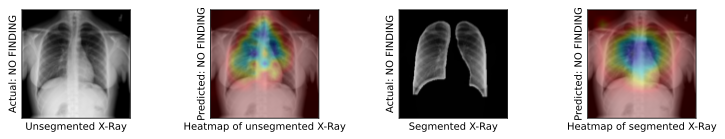

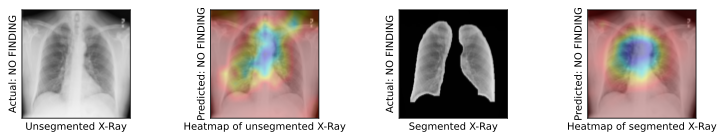

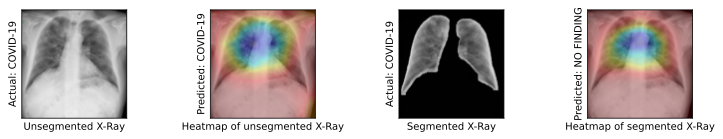

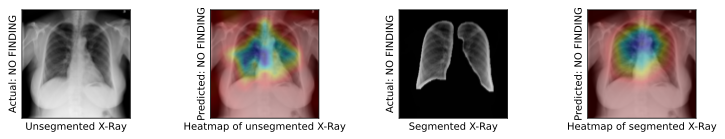

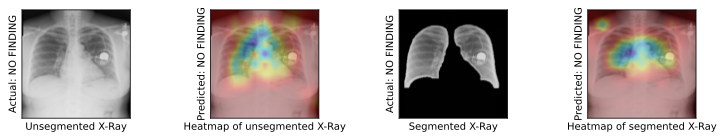

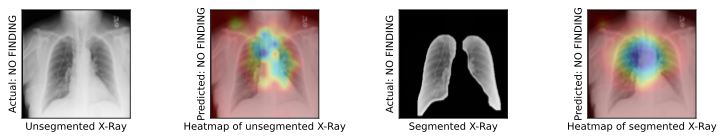

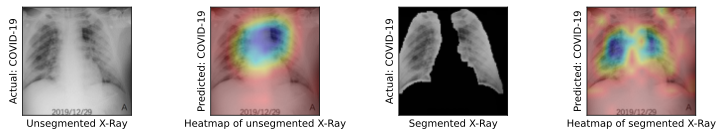

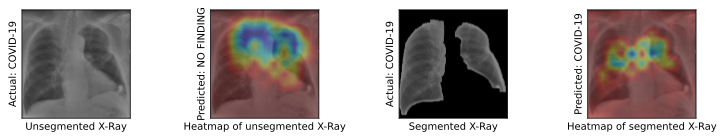

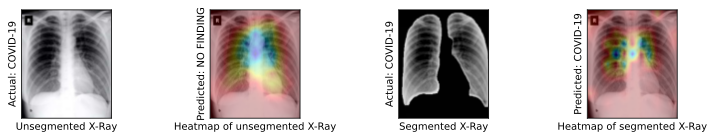

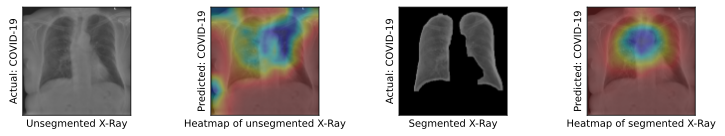

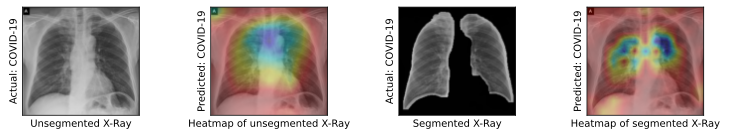

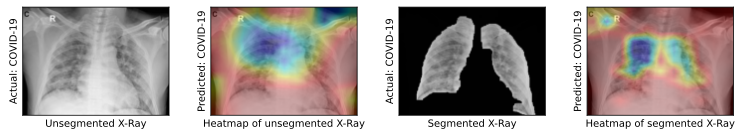

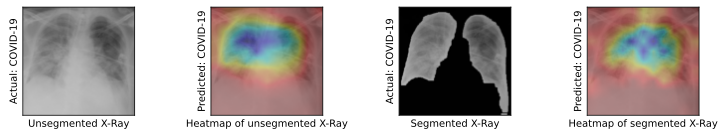

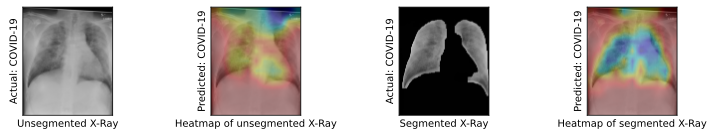

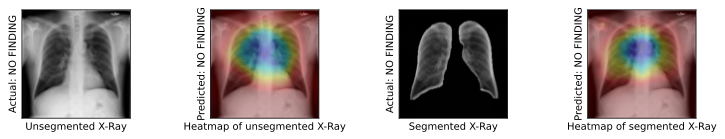

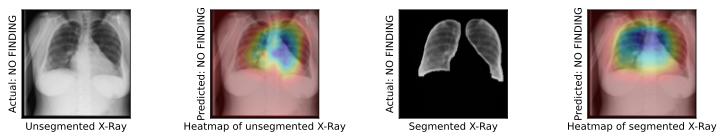

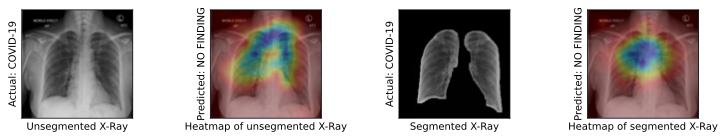

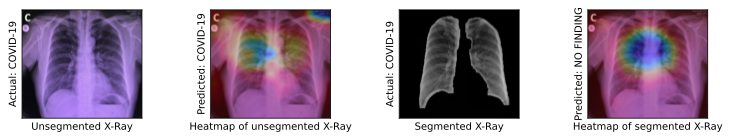

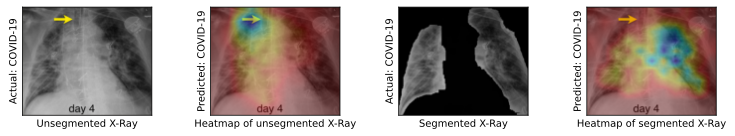

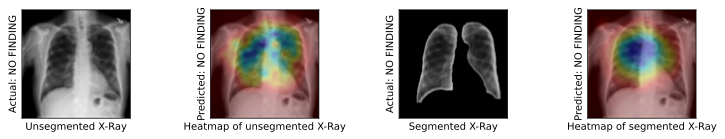

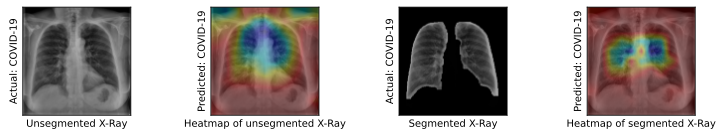

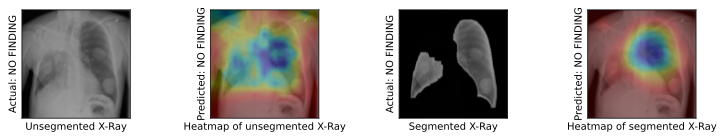

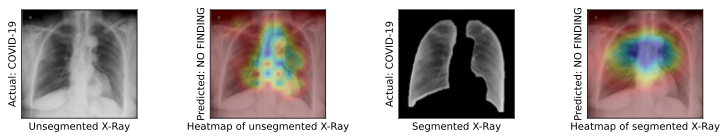

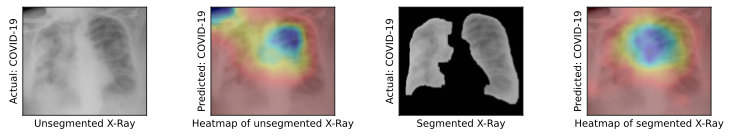

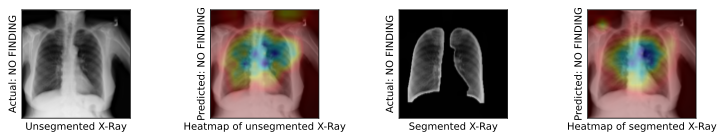

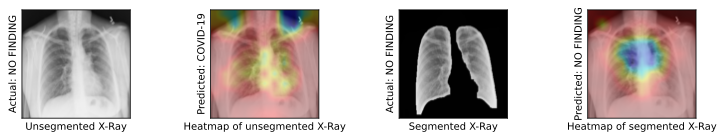

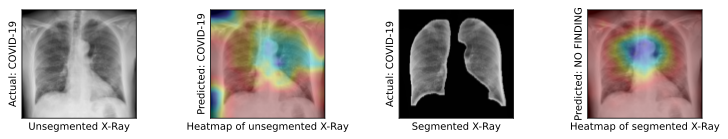

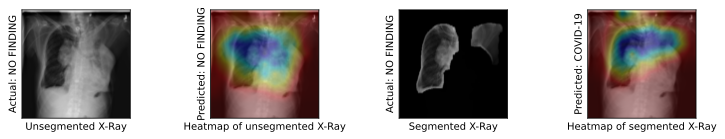

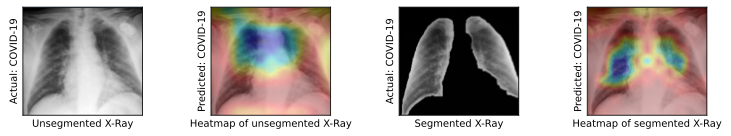

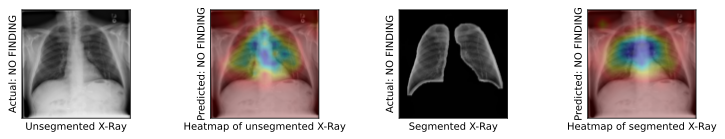

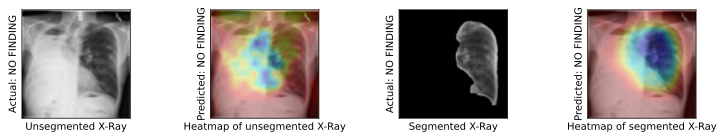

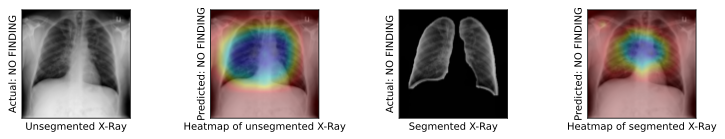

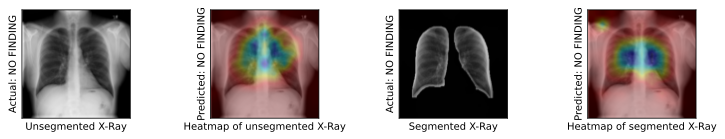

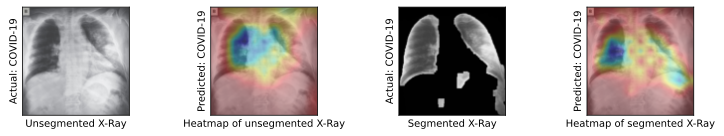

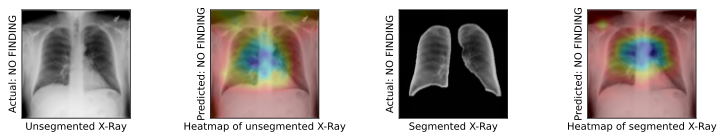

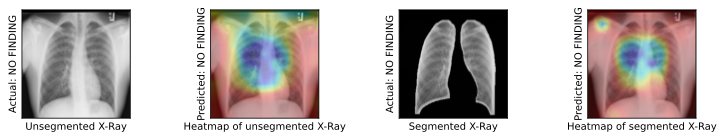

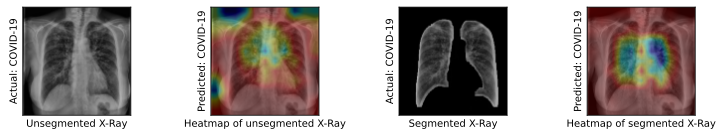

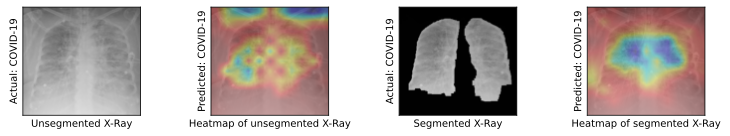

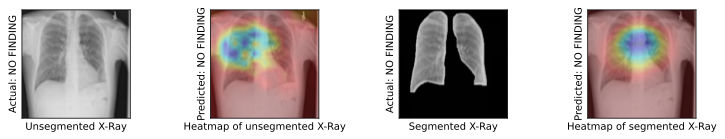

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

masked_test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

gradcam_test_generator_masked = masked_test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

print(gradcam_test_generator.class_indices)

for i in range(len(data['TEST'])):
  f, axarr = plt.subplots(1, 4)
  f.set_figheight(2)
  f.set_figwidth(13)
  img, _ = gradcam_test_generator.next()
  masked_img, _ = gradcam_test_generator_masked.next()
  
  predict = model.predict(img)
  classIdx = np.argmax(predict)

  masked_predict = segmented_model.predict(masked_img)
  masked_classIdx = np.argmax(masked_predict)

  org_classIdx = data['TEST']['label'][i]
  org_img = load_img(data['TEST']['filename'][i])
  org_img = img_to_array(org_img)
  org_masked_img = load_img(data['TEST']['masked_filename'][i])
  org_masked_img = img_to_array(org_masked_img)

  cam = My_GradCAM(model, classIdx=classIdx, inner_model=model.get_layer("NASNet"), layerName=None)
  heatmap = cam.compute_heatmap(img)
  heatmap = cv2.resize(heatmap, img_shape)
  heatmap = cv2.resize(heatmap, org_img.shape[1::-1])

  (heatmap, output) = cam.overlay_heatmap(heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)

  masked_cam = My_GradCAM(segmented_model, classIdx=masked_classIdx, inner_model=segmented_model.get_layer("NASNet"), layerName=None)
  masked_heatmap = masked_cam.compute_heatmap(masked_img)
  masked_heatmap = cv2.resize(masked_heatmap, img_shape)

  masked_heatmap = cv2.resize(masked_heatmap, org_img.shape[1::-1])

  (masked_heatmap, masked_output) = masked_cam.overlay_heatmap(masked_heatmap, org_img, alpha=0.3, colormap=cv2.COLORMAP_JET)

  #f.suptitle('{}'.format(data['TEST']['filename'][i]))
  axarr[0].imshow(org_img/255)
  #axarr[0].axis('off')
  axarr[0].set_yticks([])
  axarr[0].set_xticks([])
  axarr[0].set_xlabel('Unsegmented X-Ray')
  axarr[0].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[1].imshow(output/255)
  #axarr[1].axis('off')
  axarr[1].set_yticks([])
  axarr[1].set_xticks([])
  axarr[1].set_xlabel('Heatmap of unsegmented X-Ray')
  axarr[1].set_ylabel('Predicted: {}'.format('NO FINDING' if classIdx else 'COVID-19'))
  axarr[2].imshow(org_masked_img/255)
  #axarr[2].axis('off')
  axarr[2].set_yticks([])
  axarr[2].set_xticks([])
  axarr[2].set_xlabel('Segmented X-Ray')
  axarr[2].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[3].imshow(masked_output/255)
  #axarr[3].axis('off')
  axarr[3].set_yticks([])
  axarr[3].set_xticks([])
  axarr[3].set_xlabel('Heatmap of segmented X-Ray')
  axarr[3].set_ylabel('Predicted: {}'.format('NO FINDING' if masked_classIdx else 'COVID-19'))
  plt.savefig('/content/gradcam_segmented_vs_unsegmented/classifier_{}.svg'.format(i), dpi=256)
  plt.show()


In [ ]:
import os

import numpy as np
from lime.lime_image import *
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from tensorflow.image import per_image_standardization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class LimeExplainer():
  """
  Utilizes a tensorflow.keras.Model from a given path.

  Attributes
  ----------
  model : tensorflow.keras.Model
      classification model
  kernel_width: float
      kernel width for the exponential kernel
  feature_selection: string
      feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'
  num_features: int
      maximum number of features present in explanation
  num_samples: int
      size of the neighborhood to learn the linear model
  explanation_prefix: string:
      prefix to prepend to heatmap overlayed image filename
  """

  def __init__(
        self,
        model,
        kernel_width,
        feature_selection,
        num_features = 1000,
        num_samples = 1000,
        explanation_prefix='explanation_',
        kernel_size=2.25,
        max_dist=50,
        ratio=0.1,
        sigma=0.15
    ):
    
    self.model = model
    self.KERNEL_WIDTH = kernel_width
    self.FEATURE_SELECTION = feature_selection
    self.image_size = (331, 331)
    self.num_features = num_features
    self.num_samples = num_samples
    self.exp = LimeImageExplainer(
      kernel_width=self.KERNEL_WIDTH,
      feature_selection=self.FEATURE_SELECTION
    )
    self.explanation_prefix = explanation_prefix
    self.kernel_size = kernel_size
    self.max_dist = max_dist
    self.ratio = ratio
    self.sigma = sigma

  def explain(self, image_path, display_image_path=None):
    """Return the file path of the explain X-Ray image classification.

    Creates an explanation for the given X-Ray image,
    visualizes the explanation utilizing a heatmap,
    saves the visualization in the same folder as 
    the original X-Ray image

    Args:
      image_path: path of the image to be classified and explained
      display_image_path: if set, use different image to underlay
        heatmap. Useful, when the image used for classification has
        already been modified in previous stages (e.g. segmentation)
    """
    orig_img = image.load_img(image_path, target_size = self.image_size)
    orig_img = np.asarray(orig_img, dtype=np.float64)
    orig_img = np.expand_dims(orig_img, axis = 0)
    standardized_img = per_image_standardization(orig_img)
    standardized_img = np.squeeze(standardized_img, axis=0)

    # create explanation
    explanation = self.__predict_and_explain(
      standardized_img,
      self.model,
      self.exp, 
      self.num_features,
      self.num_samples
    )

    if display_image_path is not None:
        # use different image to underlay heatmap
        orig_img = image.load_img(display_image_path, target_size = self.image_size)
        orig_img = np.asarray(orig_img, dtype=np.float64)
        orig_img = np.expand_dims(orig_img, axis = 0)
        orig_img = np.squeeze(orig_img, axis=0)
    else:
        orig_img = np.squeeze(orig_img, axis=0)

    # overlay heatmap
    visualization = self.__visualize_explanation(
      orig_img,
      explanation
    )
    return visualization
    # Save the image
    filename = None
    dir_path = os.path.dirname(image_path)
    img_filename = self.explanation_prefix + os.path.basename(image_path)
    if dir_path is not None:
      if not os.path.exists(dir_path):
          os.makedirs(dir_path)
      filename = os.path.join(dir_path, img_filename)
      imsave(filename, visualization)
    return filename
  

  def explain_batch(self, image_paths):
    """
    Creates explainations for each image specified in image_paths.
    :param image_paths: List of image paths. If tuple, second string
        sets display_image_path
    :return: List of paths of explained images
    """
    return [
        self.explain(image_path[0], image_path[1]) if isinstance(image_path, tuple) else self.explain(image_path)
        for image_path in image_paths
    ]
      
  
  def __predict_instance(self, x, model):
    """
    Runs model prediction on 1 or more input images.
    :param x: Image(s) to predict
    :param model: A Keras model
    :return: A numpy array comprising a list of class probabilities for each prediction
    """
    y = model.predict(x)  # Run prediction on the perturbations
    if y.shape[1] == 1:
        probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
    else:
        probs = y
    return probs

  def __predict_and_explain(self, x, model, exp, num_features, num_samples):
    """
    Use the model to predict a single example and apply LIME to generate an explanation.
    :param x: Preprocessed image to predict
    :param model: The trained neural network model
    :param exp: A LimeImageExplainer object
    :param num_features: # of features to use in explanation
    :param num_samples: # of times to perturb the example to be explained
    :return: explanation
    """

    def predict(x):
      """
      Helper function for LIME explainer. Runs model prediction on perturbations of the example.
      :param x: List of perturbed examples from an example
      :return: A numpy array constituting a list of class probabilities for each predicted perturbation
      """
      return self.__predict_instance(x, model)

    # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
    segmentation_fn = SegmentationAlgorithm(
        'quickshift',
        kernel_size=self.kernel_size,
        max_dist=self.max_dist,
        ratio=self.ratio,
        sigma=self.sigma
    )
    # Generate explanation for the example
    x = np.asarray(x)
    explanation = exp.explain_instance(
        x.astype(np.float64),
        predict,
        num_features=num_features,
        num_samples=num_samples,
        segmentation_fn=segmentation_fn
    )
    probs = self.__predict_instance(
        np.expand_dims(x, axis=0),
        model
    )
    return explanation

  def __visualize_explanation(self, orig_img, explanation):
    """
    Visualize an explanation for the prediction of a single X-ray image.
    :param orig_img: Original X-Ray image
    :param explanation: ImageExplanation object
    :return: explained image
    """

    label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(
      label_to_see,
      positive_only=False, 
      num_features=10,
      hide_rest=False
    )

    explained_image = mark_boundaries(temp, mask)
    explained_image = explained_image.astype(np.uint8)
    return explained_image


In [ ]:
mkdir lime_segmented_vs_unsegmented

mkdir: cannot create directory ‘lime_segmented_vs_unsegmented’: File exists


In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import threading

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = config['DATA']['IMG_DIM']

gradcam_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

gradcam_test_generator_masked = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="masked_filename", y_col='label', target_size=img_shape, batch_size=1,
    class_mode='categorical', validate_filenames=True, shuffle=False)

lime_explainer = LimeExplainer(model, 4, 'lasso_path', kernel_size=2.5)
masked_lime_explainer = LimeExplainer(segmented_model, 4, 'lasso_path', kernel_size=2.5)

lime_img = []
masked_lime_img = []
for i in range(len(data['TEST'])):
  f, axarr = plt.subplots(1, 4)
  f.set_figheight(2)
  f.set_figwidth(13)
  img, _ = gradcam_test_generator.next()
  masked_img, _ = gradcam_test_generator_masked.next()
  if i != 25:
    continue
  predict = model.predict(img)
  classIdx = np.argmax(predict)

  masked_predict = segmented_model.predict(masked_img)
  masked_classIdx = np.argmax(masked_predict)

  org_classIdx = data['TEST']['label'][i]
  org_img = load_img(data['TEST']['filename'][i])
  org_img = img_to_array(org_img)
  org_masked_img = load_img(data['TEST']['masked_filename'][i])
  org_masked_img = img_to_array(org_masked_img)

  def ex_1():
    lime_img.append(lime_explainer.explain(data['TEST']['filename'][i]))
  def ex_2():
    masked_lime_img.append(masked_lime_explainer.explain(data['TEST']['masked_filename'][i], data['TEST']['filename'][i]))
  
  thread1 = threading.Thread(target=ex_1)
  thread2 = threading.Thread(target=ex_2)
  thread1.start()
  thread2.start()

  thread1.join()
  thread2.join()
  #f.suptitle('{}'.format(data['TEST']['filename'][i]))
  axarr[0].imshow(org_img/255)
  #axarr[0].axis('off')
  axarr[0].set_yticks([])
  axarr[0].set_xticks([])
  axarr[0].set_xlabel('Unsegmented X-Ray')
  axarr[0].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[1].imshow(lime_img[-1])
  #axarr[1].axis('off')
  axarr[1].set_yticks([])
  axarr[1].set_xticks([])
  axarr[1].set_xlabel('Heatmap of unsegmented X-Ray')
  axarr[1].set_ylabel('Predicted: {}'.format('COVID-19' if not classIdx else 'NO FINDING'))
  axarr[2].imshow(org_masked_img/255)
  #axarr[2].axis('off')
  axarr[2].set_yticks([])
  axarr[2].set_xticks([])
  axarr[2].set_xlabel('Segmented X-Ray')
  axarr[2].set_ylabel('Actual: {}'.format(org_classIdx))
  axarr[3].imshow(masked_lime_img[-1])
  #axarr[3].axis('off')
  axarr[3].set_yticks([])
  axarr[3].set_xticks([])
  axarr[3].set_xlabel('Heatmap of segmented X-Ray')
  axarr[3].set_ylabel('Predicted: {}'.format('COVID-19' if not masked_classIdx else 'NO FINDING'))
  plt.savefig('/content/lime_segmented_vs_unsegmented/image_{}.svg'.format(i), dpi=256)
  plt.show()


In [ ]:
print(data['TEST']['filename'][25])

/content/data/ChestX-ray8/00009917_001.png
